In [1]:
import os
import sys
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from joblib import dump, load
from collections import namedtuple

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [25]:
from reporting_functions import (
    get_file_content,
    get_model_result_list,
    get_result_table
)

In [32]:
quantum_exp_id_list = [136,135,134,133,132]
classical_exp_id_list = [139,140,141,142,143]
q_result_dict = {}
c_result_dict = {}
for q_id, c_id in zip(quantum_exp_id_list, classical_exp_id_list):
    q_experiment_config = get_file_content(
        f"/home/matt/dev/projects/quantum-cnn/experiments/{q_id}/experiment.json"
    )
    c_experiment_config = get_file_content(
        f"/home/matt/dev/projects/quantum-cnn/experiments/{c_id}/experiment.json"
    )
    q_result_dict[q_id] = get_model_result_list(q_experiment_config)
    c_result_dict[c_id] = get_model_result_list(c_experiment_config)

## Train History
### Prepare Data

In [33]:
q_data = pd.DataFrame()
c_data = pd.DataFrame()
for exp_id, result in q_result_dict.items():
    tmp_dict = result[0].clf.best_estimator_.train_history_.copy()
    tmp_dict["exp_id"] = [exp_id] * len(tmp_dict['Iteration'])
    q_data = pd.concat([q_data, pd.DataFrame(tmp_dict)])

for exp_id, result in c_result_dict.items():
    tmp_dict = result[0].clf.best_estimator_.train_history_.copy()
    tmp_dict["exp_id"] = [exp_id] * len(tmp_dict['Iteration'])
    c_data = pd.concat([c_data, pd.DataFrame(tmp_dict)])

### Rock vs Reggae Training History
Same configuration each time, high variability

 - **Encoding**: Angle / Qubit
 - **Scaling**: minmax(0, pi/2)
 - **Feature Selection**: 'mfcc3_var', 'mfcc4_var', 'mfcc5_var', 'mfcc6_var', 'mfcc7_var', 'mfcc8_var', 'mfcc10_var', 'mfcc13_mean'
 - **Circuit**: U_5, psatz1, 8,1, outside
 

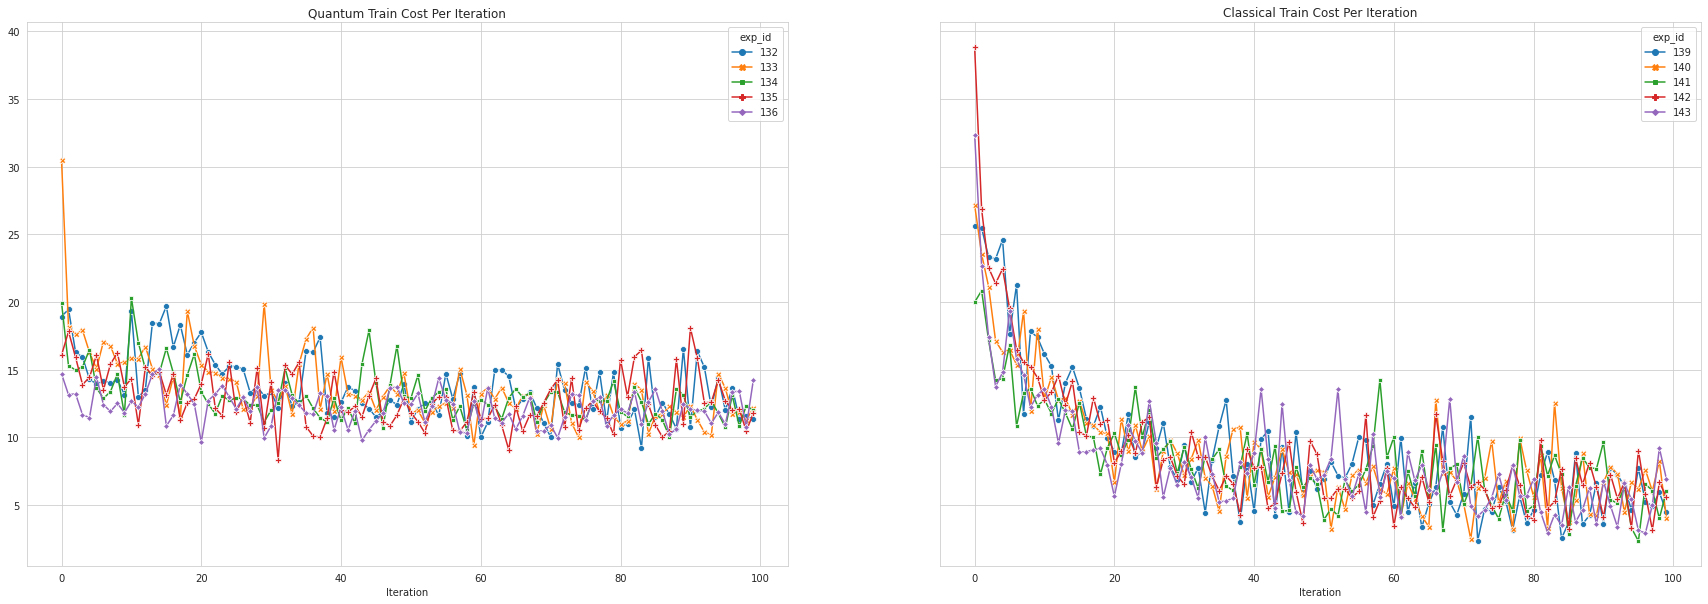

In [5]:
figsize=(30, 10)
q_plot_data = q_data.pivot("Iteration", "exp_id", "Cost")
c_plot_data = c_data.pivot("Iteration", "exp_id", "Cost")
#data = a.clf.best_estimator_.train_history_
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    sns.lineplot(
        ax=axes[0],
        data=q_plot_data,
        markers=True,
        dashes=False,
    )
    axes[0].set_title(f"Quantum Train Cost Per Iteration")
    sns.lineplot(
        ax=axes[1],
        data=c_plot_data,
        markers=True,
        dashes=False,
    )
    axes[1].set_title(f"Classical Train Cost Per Iteration")

In [45]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
result_list = [result[0] for result in q_result_dict.values()] + [result[0] for result in c_result_dict.values()]
result_data = pd.DataFrame(
    {
        "model_name": [],
        "exp_id":[],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "additional_structure_str": [],
        "circuit":[],
        "target_pair_str": [],
        "top_features" : [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result, exp_id in zip(result_list, quantum_exp_id_list + classical_exp_id_list):
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name
    tmp_result["exp_id"] = exp_id

    tmp_result["target_pair_str"] = "_".join((str(x) for x in model_configuration.target_pair))
    if model_configuration.additional_structure:
        tmp_result["additional_structure_str"] = f"{model_configuration.additional_structure[0]}_{model_configuration.additional_structure[1]}_{model_configuration.additional_structure[2]}"
        tmp_result["circuit"] = model_configuration.additional_structure[0]
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    if result.model_configuration.selection_method == "tree":
        tmp_result["top_features"] = X_test.columns[result.pipeline.named_steps.get("tree")._get_support_mask()]
    else:
        tmp_result["top_features"] = None
        

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [46]:
result_data

,model_name,exp_id,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,...,target_pair_str,top_features,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,quantum-qcnn-binary-Angle-minmax-feature_range...,136.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-13.225072,1.303637,"{'batch_size': 25, 'n_iter': 100}",0.703125,0.916667,0.379310,0.536585,None
1,quantum-qcnn-binary-Angle-minmax-feature_range...,135.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-13.951961,1.144145,"{'batch_size': 25, 'n_iter': 100}",0.562500,0.508772,1.000000,0.674419,None
2,quantum-qcnn-binary-Angle-minmax-feature_range...,134.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-13.524236,2.094200,"{'batch_size': 25, 'n_iter': 100}",0.750000,0.666667,0.896552,0.764706,None
3,quantum-qcnn-binary-Angle-minmax-feature_range...,133.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-13.770929,2.132433,"{'batch_size': 25, 'n_iter': 100}",0.781250,0.714286,0.862069,0.781250,None
4,quantum-qcnn-binary-Angle-minmax-feature_range...,132.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-14.248454,1.266531,"{'batch_size': 25, 'n_iter': 100}",0.703125,0.857143,0.413793,0.558140,None
5,classical-simple-binary-normal-minmax-feature_...,139.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-7.674766,1.621080,"{'batch_size': 25, 'n_iter': 100}",0.781250,0.777778,0.724138,0.750000,None
6,classical-simple-binary-normal-minmax-feature_...,140.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-7.419308,1.458099,"{'batch_size': 25, 'n_iter': 100}",0.796875,0.766667,0.793103,0.779661,None
7,classical-simple-binary-normal-minmax-feature_...,141.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-7.973934,1.863334,"{'batch_size': 25, 'n_iter': 100}",0.796875,0.807692,0.724138,0.763636,None
8,classical-simple-binary-normal-minmax-feature_...,142.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-7.647487,1.577409,"{'batch_size': 25, 'n_iter': 100}",0.812500,0.840000,0.724138,0.777778,None
9,classical-simple-binary-normal-minmax-feature_...,143.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1.5707963267948966]",custom_mask,support_mask=False,...,rock_reggae,None,-7.089523,1.744879,"{'batch_size': 25, 'n_iter': 100}",0.828125,0.821429,0.793103,0.807018,None


### Accuracy

In [49]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["target_pair_str" ,"algorithm","exp_id", "model_type"],
    "accuracy",
)


model_type,classical,quantum,target_pair_str Average
"(rock_reggae, qcnn, 132.0)",NaN,0.703125,0.703125
"(rock_reggae, qcnn, 133.0)",NaN,0.781250,0.781250
"(rock_reggae, qcnn, 134.0)",NaN,0.750000,0.750000
"(rock_reggae, qcnn, 135.0)",NaN,0.562500,0.562500
"(rock_reggae, qcnn, 136.0)",NaN,0.703125,0.703125
"(rock_reggae, simple, 139.0)",0.781250,NaN,0.781250
"(rock_reggae, simple, 140.0)",0.796875,NaN,0.796875
"(rock_reggae, simple, 141.0)",0.796875,NaN,0.796875
"(rock_reggae, simple, 142.0)",0.812500,NaN,0.812500
"(rock_reggae, simple, 143.0)",0.828125,NaN,0.828125


### Standard deviation

In [50]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["target_pair_str" ,"algorithm","exp_id", "model_type"],
    "std_test_score",
)


model_type,classical,quantum,target_pair_str Average
"(rock_reggae, qcnn, 132.0)",NaN,1.266531,1.266531
"(rock_reggae, qcnn, 133.0)",NaN,2.132433,2.132433
"(rock_reggae, qcnn, 134.0)",NaN,2.094200,2.094200
"(rock_reggae, qcnn, 135.0)",NaN,1.144145,1.144145
"(rock_reggae, qcnn, 136.0)",NaN,1.303637,1.303637
"(rock_reggae, simple, 139.0)",1.621080,NaN,1.621080
"(rock_reggae, simple, 140.0)",1.458099,NaN,1.458099
"(rock_reggae, simple, 141.0)",1.863334,NaN,1.863334
"(rock_reggae, simple, 142.0)",1.577409,NaN,1.577409
"(rock_reggae, simple, 143.0)",1.744879,NaN,1.744879


#### Increased batch size = 100


In [6]:
q_data = pd.DataFrame()
q_experiment_config = get_file_content(
        f"/home/matt/dev/projects/quantum-cnn/experiments/137/experiment.json"
    )
q_result_list = get_model_result_list(q_experiment_config)
tmp_dict = q_result_list[0].clf.best_estimator_.train_history_.copy()
tmp_dict["exp_id"] = [137] * len(tmp_dict['Iteration'])
q_data = pd.concat([q_data, pd.DataFrame(tmp_dict)])

c_data = pd.DataFrame()
c_experiment_config = get_file_content(
        f"/home/matt/dev/projects/quantum-cnn/experiments/144/experiment.json"
    )
c_result_list = get_model_result_list(c_experiment_config)
tmp_dict = c_result_list[0].clf.best_estimator_.train_history_.copy()
tmp_dict["exp_id"] = [exp_id] * len(tmp_dict['Iteration'])
c_data = pd.concat([c_data, pd.DataFrame(tmp_dict)])

In [7]:
#c_data

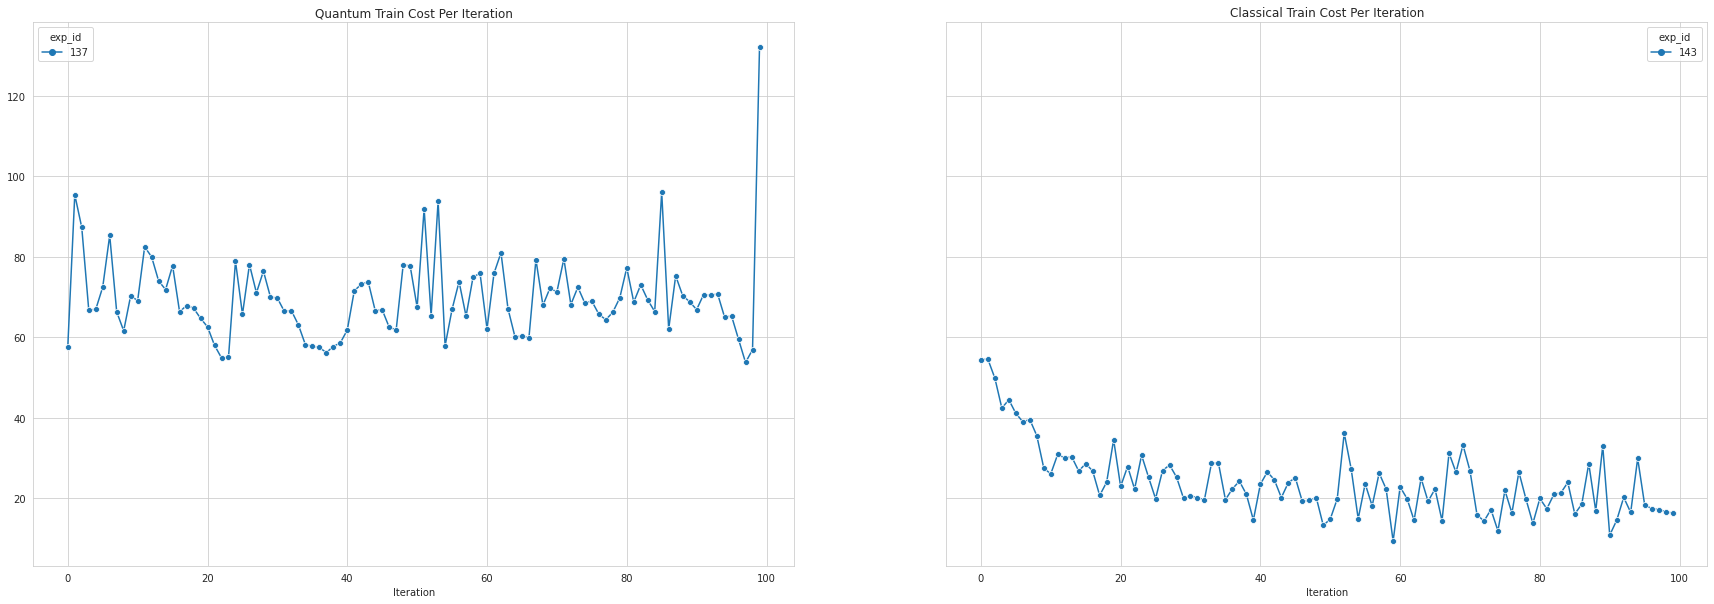

In [8]:
figsize=(30, 10)
q_plot_data = q_data.pivot("Iteration", "exp_id", "Cost")
c_plot_data = c_data.pivot("Iteration", "exp_id", "Cost")
#data = a.clf.best_estimator_.train_history_
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    sns.lineplot(
        ax=axes[0],
        data=q_plot_data,
        markers=True,
        dashes=False,
    )
    axes[0].set_title(f"Quantum Train Cost Per Iteration")
    sns.lineplot(
        ax=axes[1],
        data=c_plot_data,
        markers=True,
        dashes=False,
    )
    axes[1].set_title(f"Classical Train Cost Per Iteration")

### MNIST Image Data

Wouldn't converge frequently if good starting paramaters weren't provided

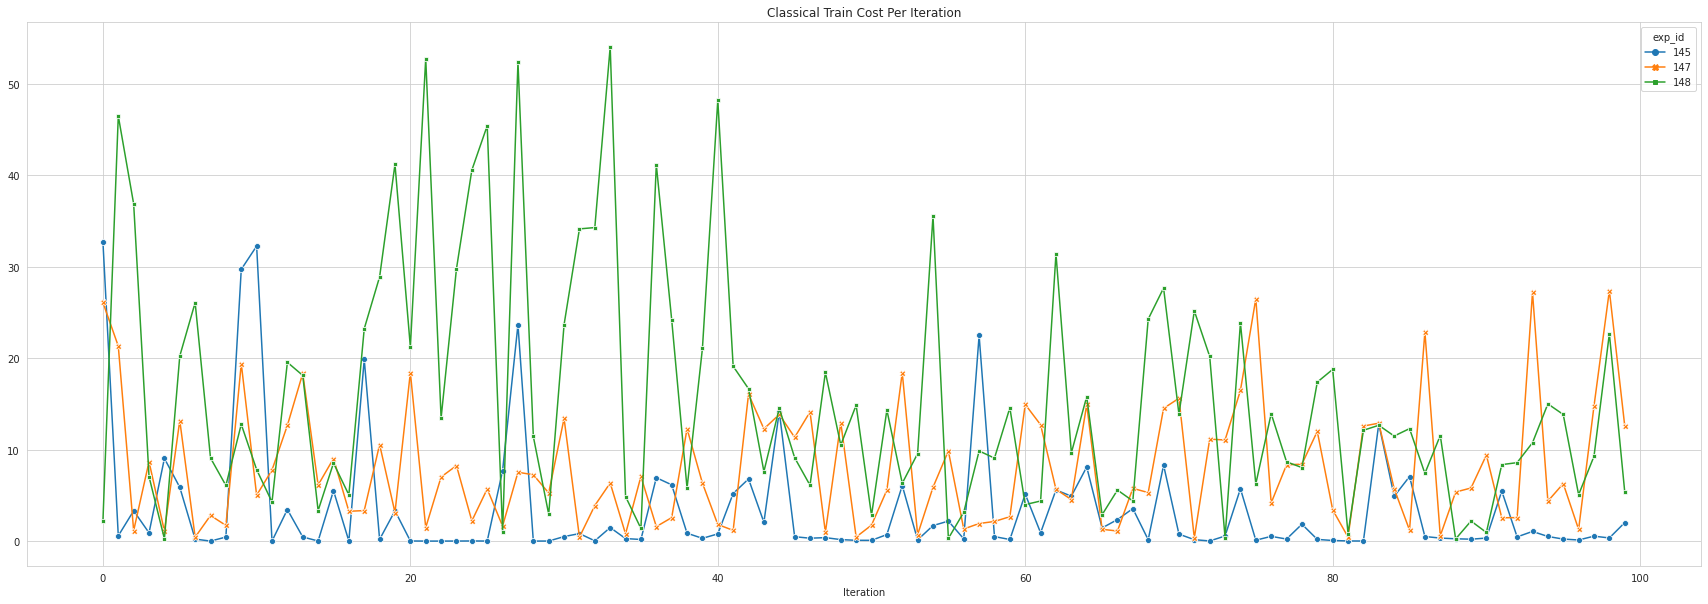

In [73]:
classical_exp_id_list = [145,147,148]

c_result_dict = {}
for c_id in classical_exp_id_list:    
    c_experiment_config = get_file_content(
        f"/home/matt/dev/projects/quantum-cnn/experiments/{c_id}/experiment.json"
    )
    c_result_dict[c_id] = get_model_result_list(c_experiment_config)

c_data = pd.DataFrame()
for exp_id, result in c_result_dict.items():
    tmp_dict = result[0].clf.best_estimator_.train_history_.copy()
    tmp_dict["exp_id"] = [exp_id] * len(tmp_dict['Iteration'])
    c_data = pd.concat([c_data, pd.DataFrame(tmp_dict)])

figsize=(30, 10)
c_plot_data = c_data.pivot("Iteration", "exp_id", "Cost")
#data = a.clf.best_estimator_.train_history_
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)
    sns.lineplot(
        ax=axes,
        data=c_plot_data,
        markers=True,
        dashes=False,
    )
    axes.set_title(f"Classical Train Cost Per Iteration")

In [78]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
result_list = [result[0] for result in c_result_dict.values()]
exp_id_list = [145,147,148]
result_data = pd.DataFrame(
    {
        "model_name": [],
        "exp_id" : [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "additional_structure_str": [],
        "circuit":[],
        "target_pair_str": [],
        "top_features" : [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result, exp_id in zip(result_list, exp_id_list):
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name
    tmp_result["exp_id"] = exp_id
    tmp_result["target_pair_str"] = "_".join((str(x) for x in model_configuration.target_pair))
    if model_configuration.additional_structure:
        tmp_result["additional_structure_str"] = f"{model_configuration.additional_structure[0]}_{model_configuration.additional_structure[1]}_{model_configuration.additional_structure[2]}"
        tmp_result["circuit"] = model_configuration.additional_structure[0]
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    if result.model_configuration.selection_method == "tree":
        tmp_result["top_features"] = X_test.columns[result.pipeline.named_steps.get("tree")._get_support_mask()]
    else:
        tmp_result["top_features"] = None
        

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [79]:
result_data.fillna("None", inplace=True)
result_data.head()

,model_name,exp_id,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,...,target_pair_str,top_features,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,classical-simple-binary-normal-minmax-feature_...,145.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1]",pca,n_components=8,...,0_1,None,None,None,"{'batch_size': 25, 'n_iter': 100}",0.979196,0.994560,0.966520,0.980340,None
1,classical-simple-binary-normal-minmax-feature_...,147.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1]",pca,n_components=8,...,0_1,None,-199.685166,53.262959,"{'batch_size': 100, 'n_iter': 100}",0.987234,0.989399,0.986784,0.988090,None
2,classical-simple-binary-normal-minmax-feature_...,148.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1]",pca,n_components=8,...,0_1,None,-25.331318,17.901868,"{'batch_size': 100, 'n_iter': 100}",0.978000,0.988889,0.970909,0.979817,None


#### Accuracy

In [82]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["algorithm", "exp_id", "target_pair_str"],
    "accuracy",
)

target_pair_str,0_1,algorithm Average
"(simple, 145.0)",0.979196,0.979196
"(simple, 147.0)",0.987234,0.987234
"(simple, 148.0)",0.978000,0.978000
exp_id Average,0.981477,0.981477


### Quantum and Classical MNIST
 0-1 and 9-1 digits

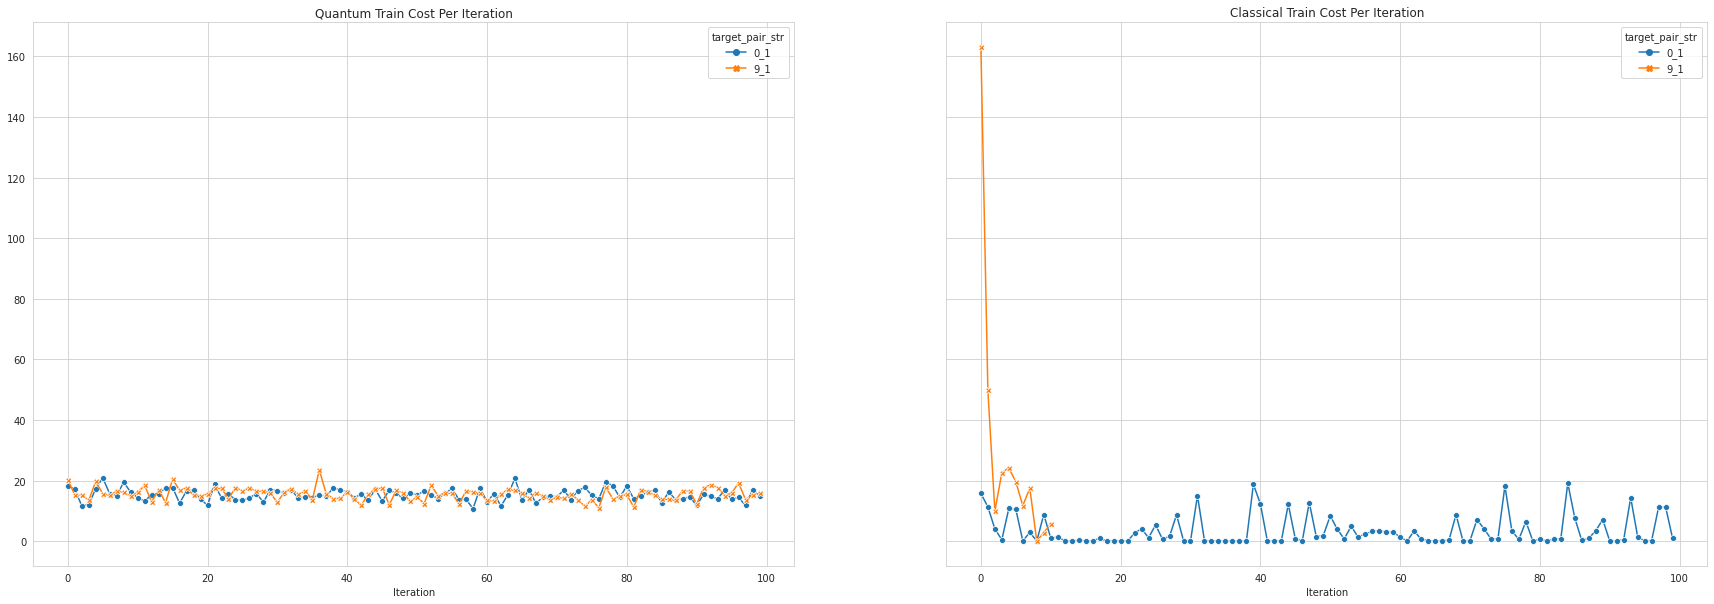

In [63]:
exp_id = 146
experiment_config = get_file_content(f"/home/matt/dev/projects/quantum-cnn/experiments/{exp_id}/experiment.json")
result_list = get_model_result_list(experiment_config)

q_data = pd.DataFrame()
c_data = pd.DataFrame()
for result in result_list:
    if result.model_configuration.model_type == "quantum":        
        target_pair = result.model_configuration.target_pair
        target_pair_str = "_".join([str(x) for x in target_pair])
        tmp_dict = result.clf.best_estimator_.train_history_.copy()
        tmp_dict["target_pair_str"] = [target_pair_str] * len(tmp_dict['Iteration'])
        q_data = pd.concat([q_data, pd.DataFrame(tmp_dict)])
    else:
        target_pair = result.model_configuration.target_pair
        target_pair_str = "_".join([str(x) for x in target_pair])
        tmp_dict = result.clf.best_estimator_.train_history_.copy()
        tmp_dict["target_pair_str"] = [target_pair_str] * len(tmp_dict['Iteration'])
        c_data = pd.concat([c_data, pd.DataFrame(tmp_dict)])

figsize=(30, 10)
q_plot_data = q_data.pivot("Iteration", "target_pair_str", "Cost")
c_plot_data = c_data.pivot("Iteration", "target_pair_str", "Cost")
#data = a.clf.best_estimator_.train_history_
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    sns.lineplot(
        ax=axes[0],
        data=q_plot_data,
        markers=True,
        dashes=False,
    )
    axes[0].set_title(f"Quantum Train Cost Per Iteration")
    sns.lineplot(
        ax=axes[1],
        data=c_plot_data,
        markers=True,
        dashes=False,
    )
    axes[1].set_title(f"Classical Train Cost Per Iteration")


In [64]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
result_data = pd.DataFrame(
    {
        "model_name": [],
        "exp_id":[],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "additional_structure_str": [],
        "circuit":[],
        "target_pair_str": [],
        "top_features" : [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result, exp_id in zip(result_list, quantum_exp_id_list + classical_exp_id_list):
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name
    tmp_result["exp_id"] = exp_id

    tmp_result["target_pair_str"] = "_".join((str(x) for x in model_configuration.target_pair))
    if model_configuration.additional_structure:
        tmp_result["additional_structure_str"] = f"{model_configuration.additional_structure[0]}_{model_configuration.additional_structure[1]}_{model_configuration.additional_structure[2]}"
        tmp_result["circuit"] = model_configuration.additional_structure[0]
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]
    
    if result.model_configuration.selection_method == "tree":
        tmp_result["top_features"] = X_test.columns[result.pipeline.named_steps.get("tree")._get_support_mask()]
    else:
        tmp_result["top_features"] = None
        

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

/home/matt/dev/projects/quantum-cnn/python_env/qcnn/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
result_data


,model_name,exp_id,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,...,target_pair_str,top_features,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,classical-simple-binary-normal-minmax-feature_...,136.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1]",pca,n_components=8,...,9_1,None,NaN,NaN,"{'batch_size': 25, 'n_iter': 100}",0.516,0.000000,0.000000,0.000000,None
1,quantum-qcnn-binary-Angle-minmax-feature_range...,135.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",pca,n_components=8,...,9_1,None,-123.678597,4.475590,"{'batch_size': 25, 'n_iter': 100}",0.672,0.659639,0.811111,0.727575,None
2,classical-simple-binary-normal-minmax-feature_...,134.0,classical,simple,binary,normal,minmax,"feature_range=[0, 1]",pca,n_components=8,...,0_1,None,NaN,NaN,"{'batch_size': 25, 'n_iter': 100}",0.982,0.992727,0.975000,0.983784,None
3,quantum-qcnn-binary-Angle-minmax-feature_range...,133.0,quantum,qcnn,binary,Angle,minmax,"feature_range=[0, 1.5707963267948966]",pca,n_components=8,...,0_1,None,-125.477684,3.497563,"{'batch_size': 25, 'n_iter': 100}",0.660,0.621622,0.824701,0.708904,None


#### Accuracy

In [67]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["algorithm", "target_pair_str"],
    "accuracy",
)


target_pair_str,0_1,9_1,algorithm Average
algorithm,,,
qcnn,0.660,0.672,0.6660
simple,0.982,0.516,0.7490
target_pair_str Average,0.821,0.594,0.7075


#### Standard Deviation

In [69]:
pd.set_option('display.max_rows', 100)
get_result_table(
    result_data,
    ["algorithm", "target_pair_str"],
    "std_test_score",
)


target_pair_str,0_1,9_1,algorithm Average
algorithm,,,
qcnn,3.497563,4.47559,3.986577
simple,NaN,NaN,NaN
target_pair_str Average,3.497563,4.47559,3.986577
